# Loading packages


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import PIL.Image

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Loading data

As this is the first stage of the project, I will aim to build only a binary classifier. The code below takes the combined CSV file with every model and variants in the dataset and subset it to only Airbus A380 and Boeing 787, two very distinct plane models.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# !mkdir /content/stage1/

In [8]:
# !cp -r /content/drive/MyDrive/GitHub_Projects/plane_variants/img/A380 /content/stage1/

In [9]:
# !cp -r /content/drive/MyDrive/GitHub_Projects/plane_variants/img/B787 /content/stage1/

In [ ]:
# all_info = pd.read_csv("/content/drive/MyDrive/GitHub_Projects/plane_variants/img/all_info.csv")
# a380vb787 = all_info.loc[all_info.model.isin(["A380", "B787"])]
# np.random.seed(456)
# a380vb787.loc[:, "purpose"] = np.random.choice(["train", "test", "validation"], size=a380vb787.shape[0], p=[0.64, 0.16, 0.2])
# a380vb787.loc[:, "download_path"] = a380vb787.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
# a380vb787.loc[:, "new_path"] = a380vb787.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
# a380vb787.head()

In [10]:
IMG_SIZE = (225, 400)
BATCH_SIZE = 32
seed = 123

# root_directory = '/content/drive/MyDrive/GitHub_Projects/plane_variants/'
# img_directory = root_directory + "img/"
img_directory = "/content/stage1/"

train_dataset = image_dataset_from_directory(
    directory=img_directory,
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split = 0.8,
    seed = seed,
    subset = "training")

type(train_dataset)
print(train_dataset)

validation_dataset = image_dataset_from_directory(
    directory=img_directory,
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split = 0.8,
    seed = seed, 
    subset = "validation")

type(validation_dataset)
print(validation_dataset)

Found 4160 files belonging to 2 classes.
Using 832 files for training.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>
Found 4160 files belonging to 2 classes.
Using 3328 files for validation.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>


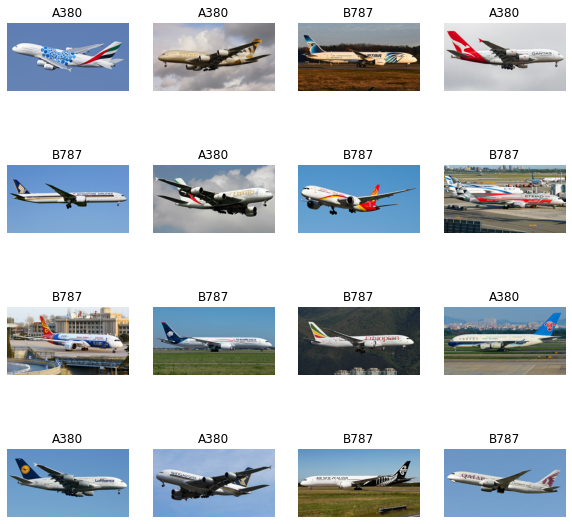

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Creating a test set

In [39]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 26
Number of validation batches: 84
Number of test batches: 20


## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this tutorial.

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

## Rescale pixel values
In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 13, 1280)


# Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

## Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 225, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 113, 200, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 113, 200, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 113, 200, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(225, 400, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model
Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

# Train the model
After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [ ]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(validation_dataset)

84/84 [==============================] - 155s 2s/step - loss: 0.7014 - accuracy: 0.4944


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
26/26 [==============================] - 208s 8s/step - loss: 0.7132 - accuracy: 0.4820 - val_loss: 0.6938 - val_accuracy: 0.5022
Epoch 2/3
26/26 [==============================] - 205s 8s/step - loss: 0.6963 - accuracy: 0.4892 - val_loss: 0.6886 - val_accuracy: 0.5022
Epoch 3/3
26/26 [==============================] - 201s 8s/step - loss: 0.6945 - accuracy: 0.5084 - val_loss: 0.6831 - val_accuracy: 0.5015


# Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

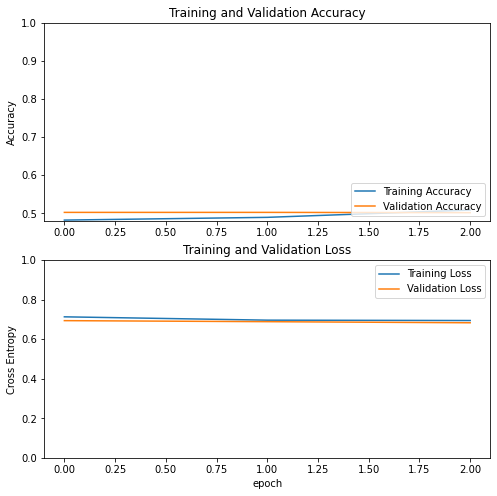

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


## Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 3/13
26/26 [==============================] - 244s 9s/step - loss: 0.6044 - accuracy: 0.5950 - val_loss: 0.5232 - val_accuracy: 0.8144
Epoch 4/13
26/26 [==============================] - 235s 9s/step - loss: 0.4441 - accuracy: 0.7837 - val_loss: 0.4182 - val_accuracy: 0.7459
Epoch 5/13
26/26 [==============================] - 245s 10s/step - loss: 0.3317 - accuracy: 0.8558 - val_loss: 0.3192 - val_accuracy: 0.8516
Epoch 6/13
26/26 [==============================] - 245s 10s/step - loss: 0.2603 - accuracy: 0.8954 - val_loss: 0.3012 - val_accuracy: 0.8177
Epoch 7/13
26/26 [==============================] - 251s 10s/step - loss: 0.1988 - accuracy: 0.9267 - val_loss: 0.2342 - val_accuracy: 0.9282
Epoch 8/13
26/26 [==============================] - 245s 10s/step - loss: 0.1634 - accuracy: 0.9447 - val_loss: 0.2004 - val_accuracy: 0.9066
Epoch 9/13
26/26 [==============================] - 246s 10s/step - loss: 0.1202 - accuracy: 0.9675 - val_loss: 0.1803 - val_accuracy: 0.9457
Epoch 10

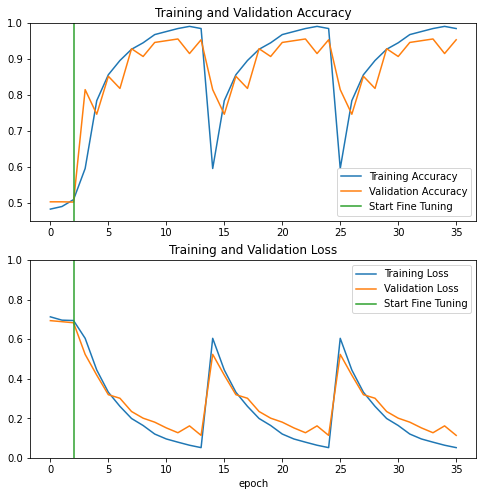

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.45, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 48s 2s/step - loss: 0.1477 - accuracy: 0.9438
Test accuracy : 0.9437500238418579


Predictions:
 [1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1]
Labels:
 [1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1]


TypeError: ignored

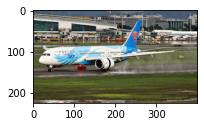

In [42]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save('/content/stage1/a380vb787')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/stage1/a380vb787/assets


In [ ]:
!zip -r /content/stage1/a380vb787.zip /content/stage1/a380vb787/

  adding: content/stage1/a380vb787/ (stored 0%)
  adding: content/stage1/a380vb787/keras_metadata.pb (deflated 96%)
  adding: content/stage1/a380vb787/assets/ (stored 0%)
  adding: content/stage1/a380vb787/saved_model.pb (deflated 92%)
  adding: content/stage1/a380vb787/variables/ (stored 0%)
  adding: content/stage1/a380vb787/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/stage1/a380vb787/variables/variables.index (deflated 77%)


# Loading model

In [3]:
model = keras.models.load_model('/content/drive/MyDrive/GitHub_Projects/plane_variants/model/a380vb787')

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [5]:
!pip install shap

     |████████████████████████████████| 358kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=2ec80e859d6eb6277f5024a6dc01956bcddd50218f03673ae08bd3ae182bfafe
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import json
import shap